<a href="https://colab.research.google.com/github/Oblachko-Js/vac-machine-learning/blob/main/vac-machine-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Установка всех нужных библиотек в Google Colab
!pip install catboost pandas numpy matplotlib scikit-learn xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import random

np.random.seed(42)

N = 30000  # размер выборки

# Районы и базовые коэффициенты
districts = {
    "Центральный": 1.35,
    "Адмиралтейский": 1.25,
    "Петроградский": 1.30,
    "Московский": 1.10,
    "Приморский": 1.05,
    "Фрунзенский": 0.95,
    "Калининский": 0.90,
    "Невский": 0.92
}

metro_stations = {
    "Невский проспект": 1.30,
    "Гостиный двор": 1.28,
    "Петроградская": 1.20,
    "Московская": 1.10,
    "Комендантский проспект": 1.05,
    "Проспект Ветеранов": 0.95,
    "Ладожская": 0.97
}

renovation_coef = {
    "без ремонта": 0.85,
    "косметический": 1.00,
    "евроремонт": 1.15,
    "дизайнерский": 1.30
}

furniture_coef = {
    "нет": 0.95,
    "частично": 1.00,
    "полностью": 1.05
}

season_coef = {
    1: 0.95, 2: 0.95, 3: 1.00,
    4: 1.02, 5: 1.05, 6: 1.10,
    7: 1.12, 8: 1.15,
    9: 1.10, 10: 1.05,
    11: 0.98, 12: 0.95
}

data = []

for _ in range(N):
    area = np.random.uniform(25, 90)
    rooms = np.random.choice([1, 2, 3], p=[0.55, 0.35, 0.10])
    floor = np.random.randint(1, 20)
    floors_total = np.random.randint(max(floor, 5), 25)

    district = random.choice(list(districts.keys()))
    metro = random.choice(list(metro_stations.keys()))
    metro_distance = np.clip(np.random.normal(10, 5), 1, 30)

    renovation = random.choice(list(renovation_coef.keys()))
    furniture = random.choice(list(furniture_coef.keys()))
    month = np.random.randint(1, 13)

    # базовая цена
    base_price = 18000 + area * 850 + rooms * 6000

    price = (
        base_price
        * districts[district]
        * metro_stations[metro]
        * renovation_coef[renovation]
        * furniture_coef[furniture]
        * season_coef[month]
        * (1 - metro_distance * 0.015)
    )

    noise = np.random.normal(0, 4000)
    price = max(15000, price + noise)

    data.append([
        round(price, 0), area, rooms, floor, floors_total,
        district, metro, round(metro_distance, 1),
        renovation, furniture, month
    ])

columns = [
    "price", "area", "rooms", "floor", "floors_total",
    "district", "metro_station", "metro_distance_min",
    "renovation_quality", "furniture", "month"
]

df = pd.DataFrame(data, columns=columns)
df.to_csv("spb_rent.csv", index=False)

print("Синтетический датасет создан")
print(df.head())
print(f"Размер выборки: {len(df)}")


Загрузка данных...
Размер выборки: 30000 объектов

Обучение и оценка моделей:

Linear Regression | MAE =     7395 руб. | R² = 0.910
Random Forest    | MAE =     6888 руб. | R² = 0.922
XGBoost          | MAE =     3779 руб. | R² = 0.977
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 28
[LightGBM] [Info] Start training from score 89288.300500


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM         | MAE =     3630 руб. | R² = 0.979
CatBoost         | MAE =     3614 руб. | R² = 0.979

Итоговое сравнение моделей:

            Model         MAE       R2
         CatBoost 3613.630507 0.979173
         LightGBM 3630.494309 0.979422
          XGBoost 3779.003386 0.977401
    Random Forest 6888.260721 0.922473
Linear Regression 7394.518193 0.909762


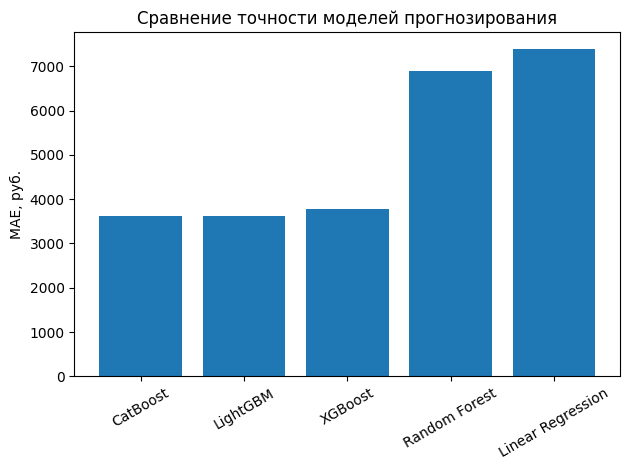

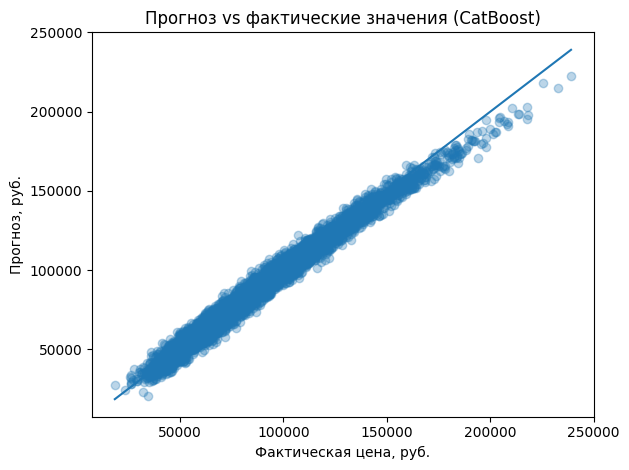


Эксперимент завершён.
Лучшая модель: CatBoost


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# =========================
# 1. Загрузка данных
# =========================

print("Загрузка данных...")
df = pd.read_csv("spb_rent.csv")

print(f"Размер выборки: {len(df)} объектов\n")


# =========================
# 2. Формирование признаков
# =========================

TARGET = "price"

NUM_FEATURES = [
    "area",
    "rooms",
    "floor",
    "floors_total",
    "metro_distance_min",
    "month"
]

CAT_FEATURES = [
    "district",
    "metro_station",
    "renovation_quality",
    "furniture"
]

X = df[NUM_FEATURES + CAT_FEATURES]
y = df[TARGET]


# =========================
# 3. Предобработка данных
# =========================

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", NUM_FEATURES),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_FEATURES)
    ]
)


# =========================
# 4. Определение моделей
# =========================

models = {
    "Linear Regression": LinearRegression(),

    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),

    "XGBoost": XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),

    "LightGBM": LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ),

    "CatBoost": CatBoostRegressor(
        iterations=400,
        depth=6,
        learning_rate=0.05,
        loss_function="MAE",
        verbose=False,
        random_seed=42
    )
}


# =========================
# 5. Разделение выборки
# =========================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# =========================
# 6. Обучение и оценка
# =========================

results = []

print("Обучение и оценка моделей:\n")

for name, model in models.items():

    pipeline = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", model)
        ]
    )

    pipeline.fit(X_train, y_train)

    preds = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append((name, mae, r2))

    print(f"{name:16s} | MAE = {mae:8.0f} руб. | R² = {r2:.3f}")


# =========================
# 7. Таблица результатов
# =========================

results_df = (
    pd.DataFrame(results, columns=["Model", "MAE", "R2"])
      .sort_values("MAE")
)

print("\nИтоговое сравнение моделей:\n")
print(results_df.to_string(index=False))


# =========================
# 8. График 1 — сравнение MAE
# =========================

plt.figure()
plt.bar(results_df["Model"], results_df["MAE"])
plt.ylabel("MAE, руб.")
plt.title("Сравнение точности моделей прогнозирования")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# =========================
# 9. График 2 — прогноз vs факт
# =========================

best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

best_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", best_model)
    ]
)

best_pipeline.fit(X_train, y_train)
best_preds = best_pipeline.predict(X_test)

plt.figure()
plt.scatter(y_test, best_preds, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)
plt.xlabel("Фактическая цена, руб.")
plt.ylabel("Прогноз, руб.")
plt.title(f"Прогноз vs фактические значения ({best_model_name})")
plt.tight_layout()
plt.show()


# =========================
# 10. Завершение
# =========================

print("\nЭксперимент завершён.")
print(f"Лучшая модель: {best_model_name}")
